# Moroccan Stocks - Portfolio Optimization with Deep Learning

#### DijkstraFTW - Decemeber 2022

## Imports

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import statsmodels.api as sm
import seaborn as sns
import itertools
from scipy.stats import *
from collections import Counter
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_percentage_error

We redefine some of the functions that we already used earlier.

In [ ]:
def getData(link) :
  r = requests.get(link)
  return r.json()

def getSectorInfoData(ISIN) :
    temp = getData("https://medias24.com/content/api?ISIN=" + ISIN +"&format=json&method=getSectorInfo")
    df = pd.DataFrame.from_dict(temp)
    return df

def getStockHistoryData(ISIN) :
    temp = getData("https://medias24.com/content/api?ISIN=" + ISIN +"&format=json&method=getPriceHistory&from=2017-01-01&to=2022-09-21")
    df = pd.DataFrame.from_dict(temp["result"])
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    return df

In [ ]:
todayStocks = getData("https://medias24.com/content/api?method=getAllStocks&format=json")

df_todayStocks = pd.DataFrame.from_dict(todayStocks["result"])
df_todayStocks['datetime'] = pd.to_datetime(df_todayStocks['datetime'], dayfirst=True, errors='coerce')
df_todayStocks.rename(columns={'name': 'name', 'name_2': 'fullName', 'volume_variation' : 'volumeVariation'}, inplace=True)
df_todayStocks.tail()

,name,fullName,ISIN,nbTitre,cours,cloture,cotation,datetime,variation,volumeVariation,volumeTitre,min,max,active
72,Delattre Lev. P,DELATTRE LEVIVIER,MA0000011777,0,70.00,"70,00",01/11/2022 à 09:48:14,2022-11-01 09:48:14,0.14,0.10,634,65.71,70.00,False
73,Auto Nejma P,AUTO NEJMA,MA0000011009,1 023 264,1817.00,"1 817,00",06/09/2022 à 14:30:52,2022-09-06 14:30:52,-8.14,-147.90,7,1817.00,1817.00,False
74,Central.Danone P/N,,MA0000012049,9 420 000,550.00,"550,00",24/06/2022 à 14:30:33,2022-06-24 14:30:33,-0.90,-4.95,259,550.00,550.00,False
75,Rebab Company P,REBAB,MA0000010993,176 456,115.00,"115,00",16/06/2022 à 14:30:35,2022-06-16 14:30:35,0.88,1.01,2,115.00,115.00,False
76,Nexans Maroc P,,MA0000011140,2 243 520,189.00,"189,00",09/12/2021 à 09:30:18,2021-12-09 09:30:18,0.00,0.00,5,189.00,189.00,False


## Stock Selection

A diversified portfolio made up of six different assets was constructed in this section. The stocks were picked so that there is very little price correlation between them and they are from various industries.

In [ ]:
df_historyStockBCP = getStockHistoryData("MA0000011884")
df_historyStockM2M = getStockHistoryData("MA0000011678")
df_historyStockLafargeHolcim = getStockHistoryData("MA0000012320")
df_historyStockCTM = getStockHistoryData("MA0000010340")
df_historyStockAddoha = getStockHistoryData("MA0000010969")
df_historyStockSteBoissons = getStockHistoryData("MA0000010365")
df_historyStockIAM = getStockHistoryData("MA0000011488")
df_historyStockPROBoA = getStockHistoryData("MA0000012437")
df_historyStockManagem = getStockHistoryData("MA0000011058")
df_historyStockAfriquia = getStockHistoryData("MA0000010951")
df_historyStockColorado = getStockHistoryData("MA0000011934")
df_historyStockAlliances = getStockHistoryData("MA0000011819")

df_historyStockCTM.tail()

,date,value,min,max,variation,volume
1169,2022-09-15,683.0,683.0,683.0,3.33,3.0
1170,2022-09-16,683.0,683.0,683.0,3.33,3.0
1171,2022-09-19,683.0,683.0,683.0,3.33,3.0
1172,2022-09-20,683.0,683.0,683.0,3.33,3.0
1173,2022-09-21,621.4,621.4,670.0,-5.99,11.0


The degree of dependency between various securities is depicted by the correlation matrix.

In [ ]:
df_groupedStocks = pd.DataFrame({})

df_groupedStocks['date'] = df_historyStockBCP['date']

df_groupedStocks['BCP'] = df_historyStockBCP['value']
df_groupedStocks['M2M'] = df_historyStockM2M['value']
df_groupedStocks['LafargeHolcim'] = df_historyStockLafargeHolcim['value']
df_groupedStocks['CTM'] = df_historyStockCTM['value']
df_groupedStocks['Addoha'] = df_historyStockAddoha['value']
df_groupedStocks['SteBoissons'] = df_historyStockSteBoissons['value']
df_groupedStocks['IAM'] = df_historyStockIAM['value']
df_groupedStocks['Managem'] = df_historyStockManagem['value']
df_groupedStocks['BoA'] = df_historyStockPROBoA['value']
df_groupedStocks['Afriquia'] = df_historyStockAfriquia['value']
df_groupedStocks['Colorado'] = df_historyStockColorado['value']
df_groupedStocks['Alliances'] = df_historyStockAlliances['value']

for i in df_groupedStocks.columns :
  df_groupedStocks[i] = df_groupedStocks[i].replace(np.nan, df_groupedStocks[i].mean())
  df_groupedStocks[i] = df_groupedStocks[i].replace(0, df_groupedStocks[i].mean())

df_groupedStocks_pct = df_groupedStocks.set_index('date').pct_change()
df_groupedStocks_pct_corr = df_groupedStocks_pct.corr()

df_groupedStocks_pct.head()

,BCP,M2M,LafargeHolcim,CTM,Addoha,SteBoissons,IAM,Managem,BoA,Afriquia,Colorado,Alliances
date,,,,,,,,,,,,
2017-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-26,0.013793,0.000410,0.047568,0.000000,-0.008715,0.044497,0.000368,0.000000,0.006604,0.000000,-0.022500,-0.019247
2017-12-27,0.001020,0.000000,0.000516,0.009993,0.000000,0.000000,0.000736,0.000000,-0.013590,0.000000,0.031074,-0.023038
2017-12-28,0.001699,0.098976,-0.020113,0.003940,-0.010989,0.000000,0.011029,0.000000,0.011876,0.000000,0.016991,-0.040611
2017-12-29,-0.002714,0.000000,0.042105,0.050633,0.000000,0.000000,-0.025455,0.015152,0.004695,0.024306,-0.000854,-0.071461


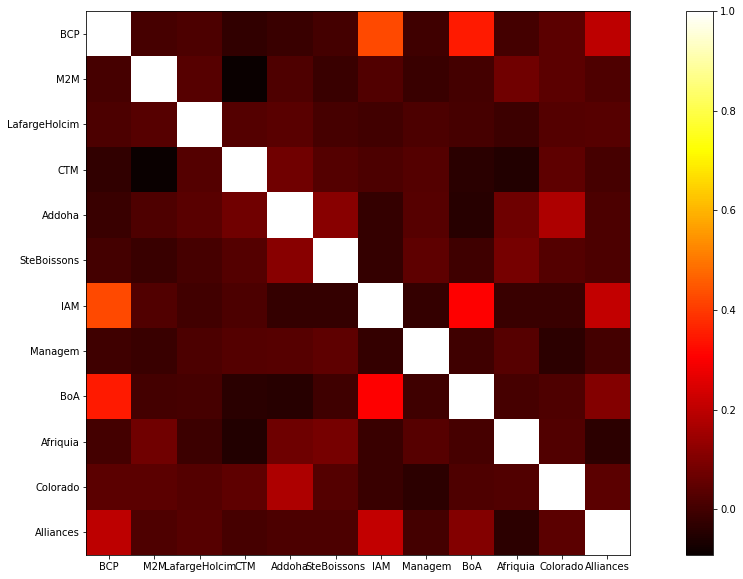

In [ ]:
plt.figure(figsize = (20,10))
plt.imshow(df_groupedStocks_pct_corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(df_groupedStocks_pct_corr)), df_groupedStocks_pct_corr.columns)
plt.yticks(range(len(df_groupedStocks_pct_corr)), df_groupedStocks_pct_corr.columns);

The final portfolio :

In [ ]:
df_portfolio = pd.DataFrame({})

df_portfolio['date'] = df_historyStockBCP['date']

df_portfolio['BCP'] = df_historyStockBCP['value']
df_portfolio['Managem'] = df_historyStockManagem['value']
df_portfolio['LafargeHolcim'] = df_historyStockLafargeHolcim['value']
df_portfolio['CTM'] = df_historyStockCTM['value']
df_portfolio['BoA'] = df_historyStockPROBoA['value']
df_portfolio['M2M'] = df_historyStockM2M['value']

df_portfolio.head()

,date,BCP,Managem,LafargeHolcim,CTM,BoA,M2M
0,2017-12-25,290.0,1650.0,1850.0,NaN,212.0,366.10
1,2017-12-26,294.0,1650.0,1938.0,NaN,213.4,366.25
2,2017-12-27,294.3,1650.0,1939.0,786.9,210.5,366.25
3,2017-12-28,294.8,1650.0,1900.0,790.0,213.0,402.50
4,2017-12-29,294.0,1675.0,1980.0,830.0,214.0,402.50


## Price predictions using LSTM

Let's select the Managem stock data :

In [ ]:
df_historyStockManagem.head()

,date,value,min,max,variation,volume
0,2017-12-25,1650.0,1609.0,1650.0,-0.06,53
1,2017-12-26,1650.0,1609.0,1650.0,0.00,53
2,2017-12-27,1650.0,1609.0,1650.0,0.00,53
3,2017-12-28,1650.0,1650.0,1650.0,0.00,3200
4,2017-12-29,1675.0,1640.0,1698.0,1.52,1585


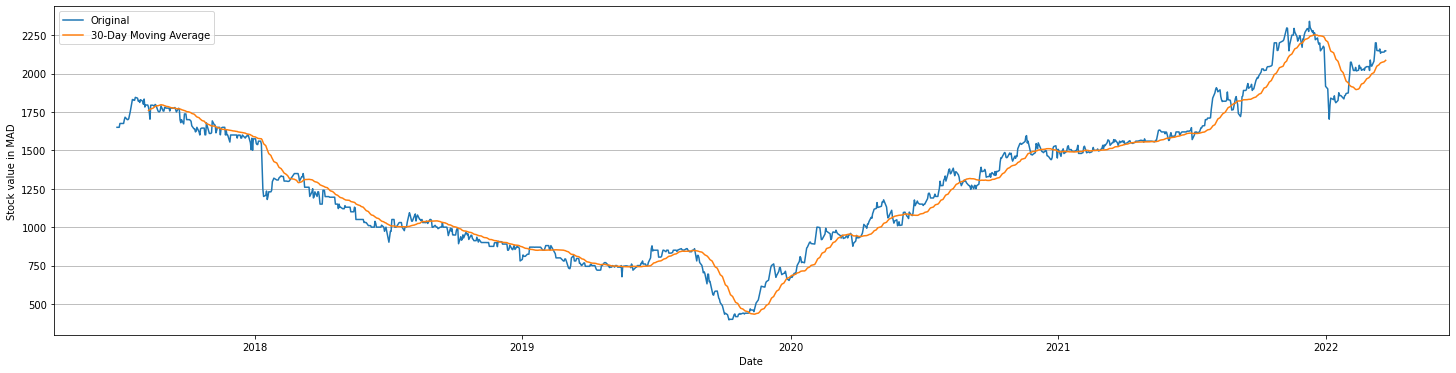

In [ ]:
df_historyStockManagem_moving_average_30 = df_historyStockManagem.copy()
df_historyStockManagem_moving_average_30['value'] = df_historyStockManagem_moving_average_30['value'].rolling(30).mean()
df_historyStockManagem_moving_average_30 = pd.DataFrame(df_historyStockManagem_moving_average_30)

formatter = mdates.DateFormatter("%Y")
plt.figure(figsize=(20,5))
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small')
plt.tight_layout()
plt.plot(df_historyStockManagem['date'], df_historyStockManagem['value'], label="Original")
plt.plot(df_historyStockManagem_moving_average_30['date'], df_historyStockManagem_moving_average_30['value'], label="30-Day Moving Average")
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Stock value in MAD")
plt.legend(loc="upper left")
plt.show()

In [ ]:
df_historyStockCTM['value'] = df_historyStockCTM['value'].replace(np.nan, df_historyStockCTM['value'].mean())
df_historyStockCTM.head()

,date,value,min,max,variation,volume
0,2017-12-25,779.114249,NaN,NaN,-100.00,NaN
1,2017-12-26,779.114249,NaN,NaN,-100.00,NaN
2,2017-12-27,786.900000,786.9,786.9,3.00,1.0
3,2017-12-28,790.000000,790.0,790.0,0.39,7.0
4,2017-12-29,830.000000,830.0,830.0,5.06,8.0


## Feature Scaling

In [ ]:
df_predictions = pd.DataFrame({})
df_errors = pd.DataFrame({}, columns=['MAPE error'])

In [ ]:
data = df_historyStockCTM
name = 'CTM'

In [ ]:
training_set = np.array(data['value']).reshape(-1,1)

scale = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scale.fit_transform(training_set)

## Preparing the training and testing sets

In [ ]:
X_train = []
y_train = []

for i in range(60, len(data) - 200) :
  X_train.append(training_set_scaled[i-60 : i, 0])
  y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_test = []
y_test = []

for i in range(len(data) - 200, len(data)) :
  X_test.append(training_set_scaled[i-60 : i, 0])
  y_test.append(training_set_scaled[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Model Construction

In [ ]:
model = Sequential()

model.add(LSTM(units= 50, return_sequences = True, input_shape = (X_train.shape[1], 1) ))
model.add(Dropout(0.2))

model.add(LSTM(units= 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units= 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units= 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_36 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_37 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_37 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_38 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_38 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_39 (LSTM)              (None, 50)               

## Prediction

In [ ]:
history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_split=0.2, shuffle=True, validation_data=(X_test, y_test), batch_size = 32)

Epoch 1/100
29/29 [==============================] - 15s 219ms/step - loss: 0.0573 - mean_absolute_error: 0.1757 - val_loss: 0.0035 - val_mean_absolute_error: 0.0510
Epoch 2/100
29/29 [==============================] - 4s 144ms/step - loss: 0.0128 - mean_absolute_error: 0.0844 - val_loss: 0.0025 - val_mean_absolute_error: 0.0353
Epoch 3/100
29/29 [==============================] - 4s 148ms/step - loss: 0.0114 - mean_absolute_error: 0.0794 - val_loss: 0.0028 - val_mean_absolute_error: 0.0440
Epoch 4/100
29/29 [==============================] - 4s 146ms/step - loss: 0.0097 - mean_absolute_error: 0.0718 - val_loss: 0.0020 - val_mean_absolute_error: 0.0343
Epoch 5/100
29/29 [==============================] - 4s 144ms/step - loss: 0.0090 - mean_absolute_error: 0.0710 - val_loss: 0.0022 - val_mean_absolute_error: 0.0380
Epoch 6/100
29/29 [==============================] - 4s 141ms/step - loss: 0.0084 - mean_absolute_error: 0.0674 - val_loss: 0.0019 - val_mean_absolute_error: 0.0336
Epoch 7/1

In [ ]:
test_predicted = model.predict(X_test)
test_inverse_predicted = scale.inverse_transform(test_predicted)

7/7 [==============================] - 3s 33ms/step


In [ ]:
d = pd.DataFrame(0, index=np.arange(len(data) - 200), columns=['prediction'])
df_invPredicted = pd.DataFrame(list(map(np.ravel, test_inverse_predicted)), columns=['value'])
df_invPredicted.tail()

,value
195,680.071045
196,679.338745
197,678.875061
198,678.703857
199,678.830078


In [ ]:
df_plot = pd.DataFrame({})

df_plot = pd.DataFrame(data['value'][:len(data) - 200])
df_plot = pd.concat([df_plot, df_invPredicted], axis = 0)
df_plot.reset_index(inplace=True)
del df_plot['index']
df_predictions[name] = df_plot

df_plot.tail()

,value
1169,680.071045
1170,679.338745
1171,678.875061
1172,678.703857
1173,678.830078


We can easily plot our results :

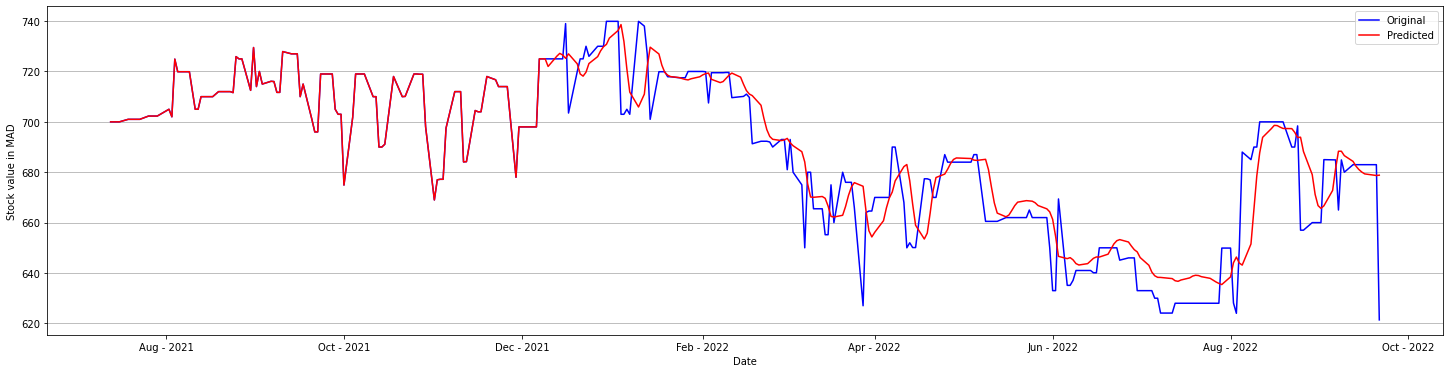

In [ ]:
formatter = mdates.DateFormatter("%b - %Y")
plt.figure(figsize=(20,5))
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small')
plt.tight_layout()
plt.plot(data['date'][len(data) - 300:], data['value'][len(data) - 300:], label="Original", color='blue')
plt.plot(data['date'][len(data) - 300:], df_plot[len(data) - 300:], label="Predicted", color='red')
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Stock value in MAD")
plt.legend(loc="upper right")
plt.show()

The model's loss and error plots :

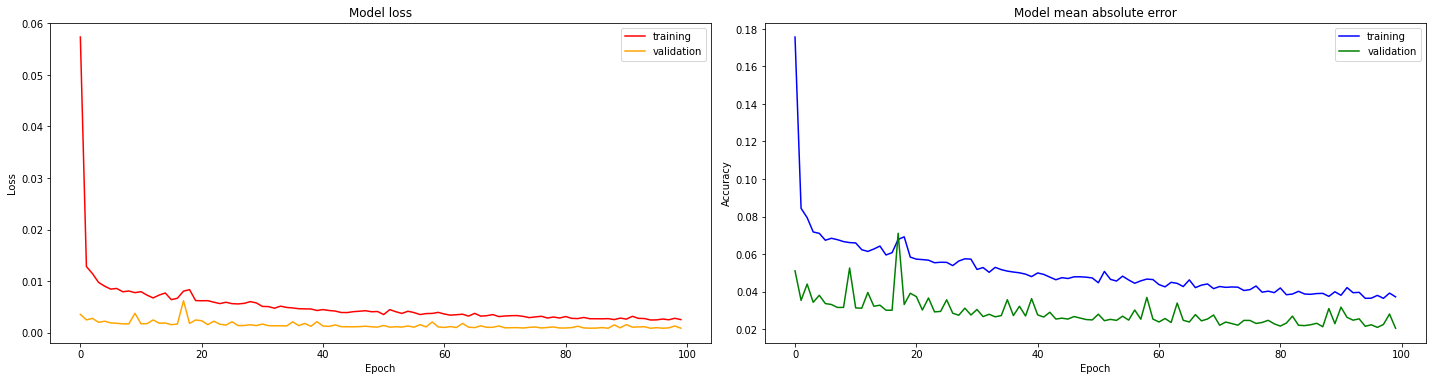

In [ ]:
plt.figure(figsize = (20,10))

plt.subplot(2,2,2)
plt.plot(history.history['mean_absolute_error'], color='blue')
plt.plot(history.history['val_mean_absolute_error'], color='green')
plt.title('Model mean absolute error')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

plt.subplot(2,2,1)
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='orange')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
error = mean_absolute_percentage_error(data['value'][len(data) - 200:], df_plot[len(data) - 200:])
df_errors.loc[name] = str("{:.2f}".format(error * 100))

## Model evaluation

We can view the prediction results after running our model for each stock.

In [ ]:
df_predictions.head()

,BCP,Managem,LafargeHolcim,CTM,BoA,M2M
0,290.0,1650.0,1850.0,779.114249,212.0,366.10
1,294.0,1650.0,1938.0,779.114249,213.4,366.25
2,294.3,1650.0,1939.0,786.900000,210.5,366.25
3,294.8,1650.0,1900.0,790.000000,213.0,402.50
4,294.0,1675.0,1980.0,830.000000,214.0,402.50


In [ ]:
df_errors

,MAPE error
BCP,1.07
Managem,4.19
LafargeHolcim,1.42
BoA,1.29
M2M,2.55
CTM,1.41


The MAPE error is quite low, which indicates that our model is performing very well.

In [ ]:
df_predictions.to_json("preds.json")

We save our results for eventual future work.

## Portfolio evaluation

We extract the prediction data.

In [ ]:
df_predictionsProcess = df_predictions[len(data) - 200:]
df_predictionsProcess

,BCP,Managem,LafargeHolcim,CTM,BoA,M2M
974,280.000000,1600.000000,2107.000000,721.987915,185.000000,737.661133
975,279.000000,1620.000000,2107.000000,726.063538,187.500000,723.344543
976,277.050000,1595.609985,2107.000000,727.181885,186.000000,704.200317
977,275.500000,1600.425903,2120.000000,726.527527,186.000000,682.853699
978,280.000000,1605.338989,2095.195557,725.219421,186.000000,670.753601
...,...,...,...,...,...,...
1176,257.874329,NaN,1794.956909,NaN,178.175522,NaN
1177,257.970032,NaN,1805.335083,NaN,178.143555,NaN
1178,258.025665,NaN,NaN,NaN,178.153610,NaN
1179,258.069275,NaN,NaN,NaN,178.260010,NaN


We will reuse the methodology we followed in our preliminary analysisfor portfolio evaluation :

In [ ]:
logReturns = np.log(df_predictionsProcess/df_predictionsProcess.shift(1))
covMatrix = logReturns.cov() * 75

PortfoliosNum = 3000
weights = np.zeros((PortfoliosNum, len(df_predictionsProcess.columns)))
PortfoliosReturns = np.zeros((PortfoliosNum))
PortfoliosRisk = np.zeros((PortfoliosNum))
SharpeRatio = np.zeros((PortfoliosNum))

for i in range(PortfoliosNum) :
  w = np.random.uniform(size = len(df_predictionsProcess.columns))
  w = w/np.sum(w)

  weights[i, :] = w

  tempReturns = np.sum(logReturns.mean() * w)
  tempReturns = (tempReturns + 1) ** 75 - 1
  PortfoliosReturns[i] = tempReturns

  tempRiskSd = np.sqrt(np.dot(w.T, np.dot(covMatrix, w)))
  PortfoliosRisk[i] = tempRiskSd

  tempSR = tempReturns/tempRiskSd
  SharpeRatio[i] = tempSR

minVar = weights[PortfoliosRisk.argmin()]
maxSR = weights[SharpeRatio.argmax()]
asset = df_predictionsProcess.columns

minVar = pd.Series(minVar, index=asset)
minVar = minVar.sort_values()

maxSR = pd.Series(maxSR, index=asset)
maxSR = maxSR.sort_values()

The weights distribution, efficient frontier, and expected closing prices of this portfolio are :

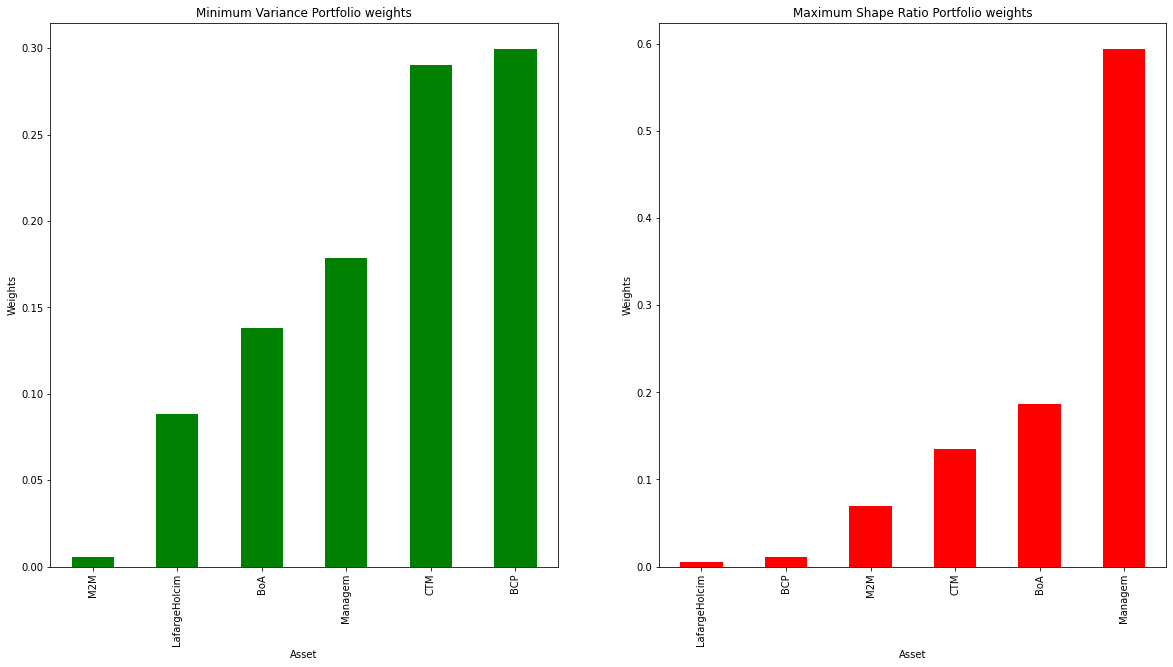

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot(1, 2, 1)
ax1.set_xlabel("Asset")
ax1.set_ylabel("Weights")
ax1.set_title("Minimum Variance Portfolio weights")
minVar.plot(kind = 'bar', color='green')

ax2 = plt.subplot(1, 2, 2)
ax2.set_xlabel("Asset")
ax2.set_ylabel("Weights")
ax2.set_title("Maximum Shape Ratio Portfolio weights")
maxSR.plot(kind = 'bar', color='red')

plt.show()

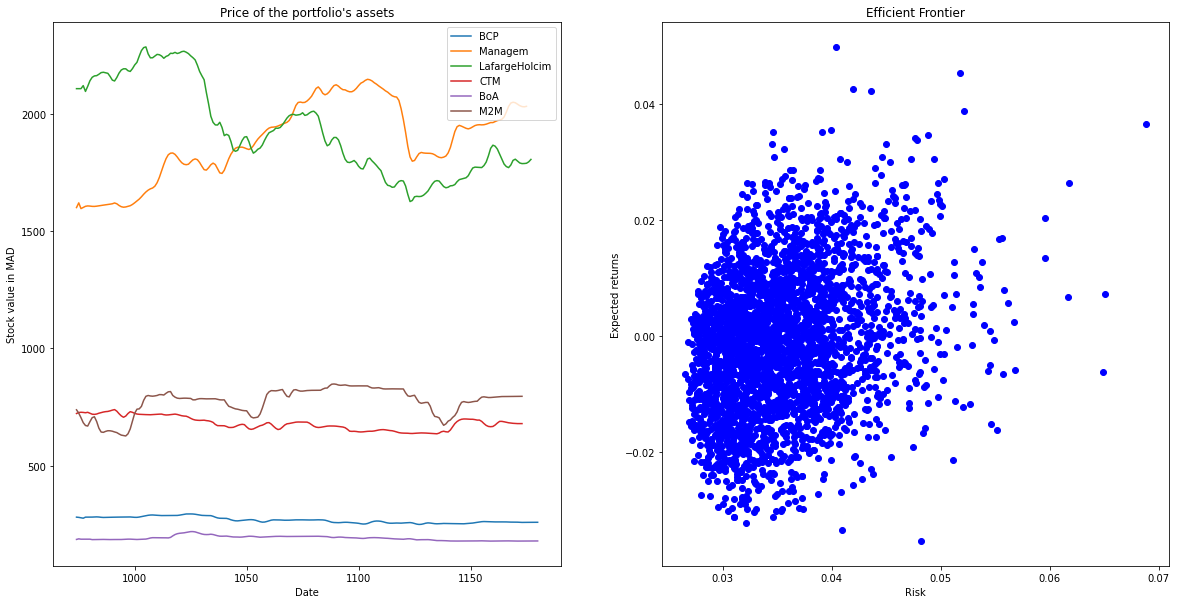

In [ ]:
fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot(1, 2, 1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock value in MAD")
ax1.set_title("Price of the portfolio's assets")
ax1.plot(df_predictions[len(data) - 200:])
ax1.legend(['BCP',	'Managem',	'LafargeHolcim',	'CTM',	'BoA',	'M2M'], loc='upper right')

ax2 = plt.subplot(1, 2, 2)
ax2.scatter(PortfoliosRisk, PortfoliosReturns, color="blue")
ax2.set_ylabel('Expected returns')
ax2.set_xlabel('Risk')
ax2.set_title("Efficient Frontier")


plt.show()

In [ ]:
df_PredictionsPortfolio_Result = pd.DataFrame(minVar)
df_PredictionsPortfolio_Result = df_PredictionsPortfolio_Result.rename(columns={0 : "Optimal weights"})
df_PredictionsPortfolio_Result["Optimal Sharpe ratio"] = maxSR
df_PredictionsPortfolio_Result

,Optimal weights,Optimal Sharpe ratio
M2M,0.005412,0.069000
LafargeHolcim,0.088392,0.004741
BoA,0.137994,0.186351
Managem,0.178344,0.594235
CTM,0.290227,0.134547
BCP,0.299631,0.011125


In [ ]:
print("Portfolio annual return : " + str(round(max(PortfoliosReturns) *100, 2)) + "%\n" +
      "Portfolio volatility : " + str(round(min(PortfoliosRisk) * 100, 2)) + "%\n" +
      "Sharpe ratio : " + str(round(SharpeRatio.max(), 2)))

Portfolio annual return : 4.99%
Portfolio volatility : 2.66%
Sharpe ratio : 1.24


We were able to create a portfolio using that overperformed those we created using traditional techniques.